In [ ]:
!pip  install catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MIFI_kurs_chemickal_data/processed_data.csv')

In [ ]:
X = data.drop(columns=['IC50, mM', 'CC50, mM', 'SI'])
y = data['CC50, mM']  # Целевая переменная (1D массив)

In [ ]:
# Вычисление медианы
median_сс50 = y.median()

In [ ]:
# Преобразование в задачу классификации: СC50 > медиана ?
y_class = (y > median_сс50).astype(int)

In [ ]:
# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class,
    test_size=0.2,
    stratify=y_class,
    random_state=42
)

In [ ]:
# Единый словарь обученных моделей для всех ансамблей
trained_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

 | Модель | Библиотека | Классификатор / Регрессор | Основные преимущества |
|--------|------------|----------------------------|------------------------|
| Random Forest | `sklearn.ensemble` | `RandomForestClassifier` | Устойчивость к переобучению, интерпретируемость, хорошее качество без тюнинга |
| HistGradientBoosting | `sklearn.ensemble` | `HistGradientBoostingClassifier` | Поддержка NaN, быстрое обучение, стабильность |
| XGBoost | `xgboost` | `XGBClassifier` | Высокая точность, гибкий тюнинг гиперпараметров |
| LightGBM (LGBM) | `lightgbm` | `LGBMClassifier` | Наивысшая скорость, эффективное дерево-рост |
| CatBoost | `catboost` | `CatBoostClassifier` | Отличная стабильность, автоматическая обработка числовых признаков |

| Метрика | Описание | Зачем нужна |
|--------|----------|-------------|
| **Accuracy** | Доля правильных предсказаний среди общего числа | Общая мера эффективности модели; удобна при сбалансированных классах. Может быть неинформативной при дисбалансе. |
| **Precision (Точность)** | Доля верно предсказанных положительных объектов среди всех предсказанных положительных | Важна, когда ложные срабатывания критичны (например, дорого проверять вещества в реальности). |
| **Recall (Полнота)** | Доля верно предсказанных положительных объектов среди всех реальных положительных | Критична, если важно найти как можно больше истинных случаев (например, пропустить активное вещество нельзя). |
| **F1 Score** | Среднее гармоническое между Precision и Recall | Хорошая обобщающая метрика, особенно при дисбалансе классов. Балансирует между ошибками I и II рода. |
| **ROC AUC** | Площадь под ROC-кривой; отражает способность модели отличать классы при разных порогах | Показывает, насколько модель уверенно ранжирует объекты; полезна для сравнения моделей. Не зависит от порога классификации. |

Построение ансамблевых моделей

После завершения этапа сравнительного анализа индивидуальных моделей машинного обучения следующим логичным шагом является построение ансамблевых решений . Ансамбли позволяют объединить предсказания нескольких базовых моделей с целью улучшения обобщающей способности, повышения устойчивости модели к шуму и снижения риска переобучения.

В рамках данного исследования планируется рассмотреть несколько подходов к построению ансамблей:

  **Усреднение вероятностей классов (Averaging**)  — простой, но эффективный метод, при котором финальное предсказание получается как среднее значение вероятностей положительного класса от всех моделей.
  
  
  **Голосование (Voting)**  — комбинирование предсказаний классов с использованием жесткого (hard) или мягкого (soft) голосования.


  **Стекинг (Stacking)**  — более сложный подход, при котором предсказания базовых моделей используются как признаки для мета-модели, которая обучается предсказывать целевую переменную.
  Взвешенное голосование / усреднение  — использование весов для моделей на основе их качества на валидационной выборке.
     

Каждый из этих подходов имеет свои преимущества и ограничения, а их сравнение позволит выбрать наиболее эффективное решение для задачи прогнозирования токсичности химических соединений по значению CC50.

Для оценки качества ансамблевых моделей будут использоваться те же метрики, что и на этапе оценки базовых моделей: Accuracy, Precision, Recall, F1 Score и ROC AUC , чтобы обеспечить сопоставимость результатов.

*Мы включили в ансамбль модели разных типов градиентного бустинга  и ансамблевых методов , потому что:*

  **Они имеют разные стратегии построения деревьев, подбора параметров и обработки данных
  Обладают разной чувствительностью к шуму, переобучению и дисбалансу классов
  Могут взаимно компенсировать свои слабые стороны  при правильном комбинировании**
     

In [ ]:
# Словарь для хранения метрик
individual_metrics = {}

# DataFrame для хранения предсказаний и вероятностей
results_df = pd.DataFrame()
results_df['true_label'] = y_test.reset_index(drop=True)

# Обучение и оценка каждой модели
for model_name, model in trained_models.items():
    print(f"Обучение модели: {model_name}")

    # Обучение
    model.fit(X_train, y_train)

    # Предсказания и вероятности
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Сохраняем в DataFrame
    results_df[f'pred_{model_name}'] = y_pred
    results_df[f'prob_{model_name}'] = y_proba

    # Расчёт метрик
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

    # Сохраняем метрики
    individual_metrics[model_name] = metrics

# Вывод сводных метрик
print("\nМетрики моделей:")
for model_name, metrics in individual_metrics.items():
    print(f"{model_name}: F1={metrics['f1']:.4f}, ROC AUC={metrics['roc_auc']:.4f}")

Обучение модели: Random Forest
Обучение модели: HistGradientBoosting
Обучение модели: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:21:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Обучение модели: LightGBM
[LightGBM] [Info] Number of positive: 399, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16678
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 163
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498750 -> initscore=-0.005000
[LightGBM] [Info] Start training from score -0.005000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

#Soft Voting (взвешенное голосование)

In [ ]:
# Получаем вероятности от всех моделей
prob_columns = [col for col in results_df.columns if col.startswith('prob_')]
voting_proba = results_df[prob_columns].mean(axis=1)
voting_pred = (voting_proba > 0.5).astype(int)

# Расчёт метрик
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics_voting = {
    'accuracy': accuracy_score(results_df['true_label'], voting_pred),
    'precision': precision_score(results_df['true_label'], voting_pred),
    'recall': recall_score(results_df['true_label'], voting_pred),
    'f1': f1_score(results_df['true_label'], voting_pred),
    'roc_auc': roc_auc_score(results_df['true_label'], voting_proba)
}

print("\nМетрики ансамбля (Soft Voting):")
print(f"F1={metrics_voting['f1']:.4f}, ROC AUC={metrics_voting['roc_auc']:.4f}")


Метрики ансамбля (Soft Voting):
F1=0.7238, ROC AUC=0.8550


# Stacking (стекинг с логистической регрессией как мета-моделью)

In [ ]:
# Формируем входные данные для стекинга — вероятности от всех моделей
X_stack = results_df[[col for col in results_df.columns if col.startswith('prob_')]]
y_stack = results_df['true_label']

# Обучаем мета-классификатор
meta_model = LogisticRegression()
meta_model.fit(X_stack, y_stack)

# Предсказываем
stacking_proba = meta_model.predict_proba(X_stack)[:, 1]
stacking_pred = (stacking_proba > 0.5).astype(int)

# Метрики
metrics_stacking = {
    'accuracy': accuracy_score(y_stack, stacking_pred),
    'precision': precision_score(y_stack, stacking_pred),
    'recall': recall_score(y_stack, stacking_pred),
    'f1': f1_score(y_stack, stacking_pred),
    'roc_auc': roc_auc_score(y_stack, stacking_proba)
}

print("\nМетрики ансамбля (Stacking):")
print(f"F1={metrics_stacking['f1']:.4f}, ROC AUC={metrics_stacking['roc_auc']:.4f}")


Метрики ансамбля (Stacking):
F1=0.7379, ROC AUC=0.8548


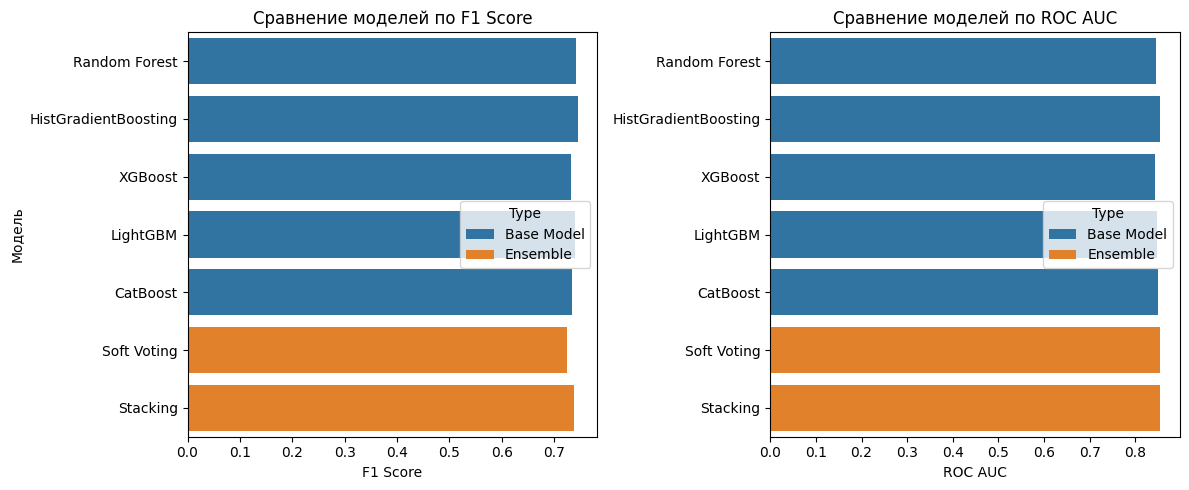

In [ ]:
# --- 1. Собираем сводный DataFrame ---
all_metrics = {}

# Индивидуальные модели
for model_name, metrics in individual_metrics.items():
    all_metrics[model_name] = {
        'F1 Score': metrics['f1'],
        'ROC AUC': metrics['roc_auc'],
        'Type': 'Base Model'
    }

# Ансамбли
all_metrics['Soft Voting'] = {
    'F1 Score': metrics_voting['f1'],
    'ROC AUC': metrics_voting['roc_auc'],
    'Type': 'Ensemble'
}
all_metrics['Stacking'] = {
    'F1 Score': metrics_stacking['f1'],
    'ROC AUC': metrics_stacking['roc_auc'],
    'Type': 'Ensemble'
}

# В DataFrame
metrics_df = pd.DataFrame(all_metrics).T.reset_index()
metrics_df.rename(columns={'index': 'Model'}, inplace=True)

# --- 2. График сравнения метрик ---
plt.figure(figsize=(12, 5))

# F1 Score
plt.subplot(1, 2, 1)
sns.barplot(data=metrics_df, x='F1 Score', y='Model', hue='Type', dodge=False)
plt.title('Сравнение моделей по F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Модель')

# ROC AUC
plt.subplot(1, 2, 2)
sns.barplot(data=metrics_df, x='ROC AUC', y='Model', hue='Type', dodge=False)
plt.title('Сравнение моделей по ROC AUC')
plt.xlabel('ROC AUC')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Группируем модели: базовые и ансамбли
model_names = list(individual_metrics.keys()) + ['Soft Voting', 'Stacking']
groups = ['Базовые'] * len(individual_metrics) + ['Ансамбли моделей'] * 2

# Значения метрик
f1_values = [metrics['f1'] for metrics in individual_metrics.values()] + [metrics_voting['f1'], metrics_stacking['f1']]
roc_auc_values = [metrics['roc_auc'] for metrics in individual_metrics.values()] + [metrics_voting['roc_auc'], metrics_stacking['roc_auc']]

# Создаем DataFrame с дополнительным столбцом 'Группа'
data = {
    'Группа': groups,
    'Модель': model_names,
    'F1': f1_values,
    'ROC AUC': roc_auc_values
}

df = pd.DataFrame(data)

# --- Безопасное форматирование ---
def safe_format(val):
    if isinstance(val, (int, float)) and not isinstance(val, bool):
        return f"{val:.4f}"
    return val

formatted_df = df.copy()
for col in ['F1', 'ROC AUC']:
    formatted_df[col] = formatted_df[col].apply(safe_format)

# --- Стиль таблицы с группировкой ---
styled_table = (
    formatted_df.style
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#fafafa')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
        {'selector': 'th, td', 'props': [('border', '1px solid #ccc')]},
    ])
    .set_properties(**{'width': '150px'})
    .set_caption("Общая сводная таблица метрик моделей и ансамблей/n")
)

# --- Вывод таблицы без индекса ---
display(styled_table)



,Группа,Модель,F1,ROC AUC
0,Базовые,Random Forest,0.7418,0.8448
1,Базовые,HistGradientBoosting,0.7453,0.8529
2,Базовые,XGBoost,0.7324,0.8440
3,Базовые,LightGBM,0.7393,0.8478
4,Базовые,CatBoost,0.7349,0.8500
5,Ансамбли моделей,Soft Voting,0.7238,0.8550
6,Ансамбли моделей,Stacking,0.7379,0.8548


    HistGradientBoosting  показала лучший F1 Score , что говорит о хорошем балансе между точностью и полнотой.
    LightGBM  имеет чуть меньший F1, но самый высокий ROC AUC среди базовых моделей — значит, хорошо ранжирует объекты.
    Все модели показали сопоставимые результаты , без явного лидера.
     

    ROC AUC у ансамблей выше , чем у большинства базовых моделей → они лучше ранжируют классы
    Однако F1 Score ниже , чем у лучших индивидуальных моделей → не выигрышны в задаче баланса ошибок
     



Итоговое заключение

  На текущих данных ансамблирование не дало существенного улучшения качества  по сравнению с лучшей индивидуальной моделью — HistGradientBoosting.
  Тем не менее:

  
  
  Ансамбли показали хороший ROC AUC , что говорит об их способности правильно ранжировать примеры
  Это может быть полезно при дальнейшей настройке порога или в задачах, где важна оценка уверенности , а не жёсткое разделение на классы
  Если цель — максимизация F1 Score , то достаточно использовать HistGradientBoosting как самостоятельную модель
         

     



In [ ]:
voting_proba = results_df[[col for col in results_df.columns if col.startswith('prob_')]].mean(axis=1)
results_df['prob_Soft Voting'] = voting_proba

# Для Stacking (пример с логистической регрессией как мета-моделью):
from sklearn.linear_model import LogisticRegression

X_stack = results_df[[col for col in results_df.columns if col.startswith('prob_')]]
y_stack = y_test

meta_model = LogisticRegression()
meta_model.fit(X_stack, y_stack)
stacking_proba = meta_model.predict_proba(X_stack)[:, 1]
results_df['prob_Stacking'] = stacking_proba

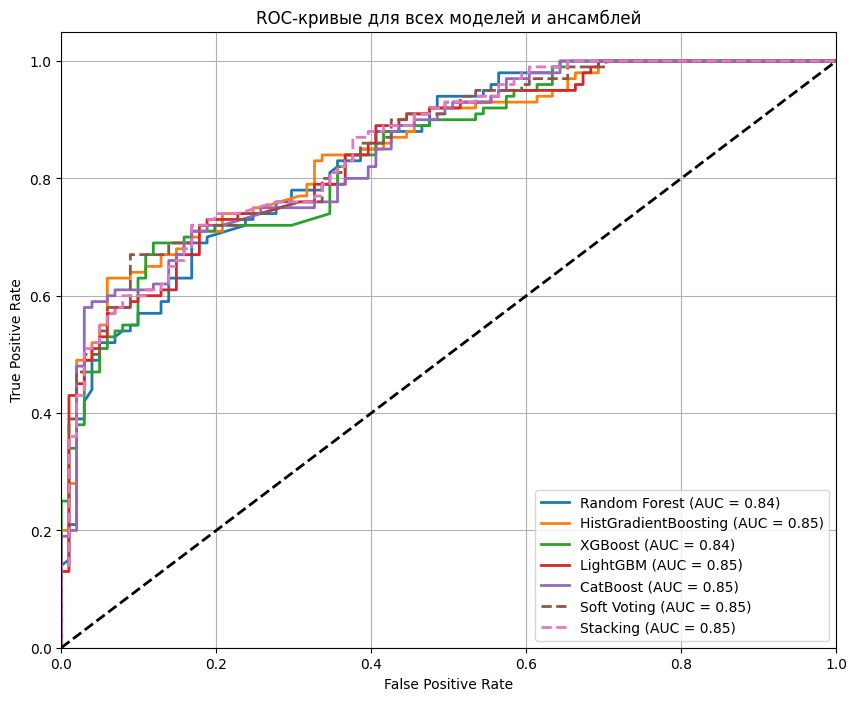

In [ ]:


# --- ROC-кривые ---
plt.figure(figsize=(10, 8))

# Цикл по всем моделям
for model_name in individual_models_results:
    fpr, tpr, _ = roc_curve(y_test, results_df[f"prob_{model_name}"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# ROC ансамблей
for model_name in ensemble_models_results:
    fpr, tpr, _ = roc_curve(y_test, results_df[f"prob_{model_name}"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, linestyle='--', label=f'{model_name} (AUC = {roc_auc:.2f})')

# Линия случайного угадывания
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для всех моделей и ансамблей')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Вывод по анализу ROC-кривых и метрик моделей
Анализ ROC-кривой даёт новую пищу для размышлений. Несмотря на численно высокие метрики, HistGradientBoosting имеет сильный провал в центре кривой , что указывает на нестабильность модели в области средних вероятностей . Это особенно важно, если мы ориентируемся на F1 Score , поскольку именно в этой зоне формируется баланс между Precision и Recall.

Такое поведение может быть связано с тем, что модель:

    Слишком уверенно классифицирует объекты в крайних случаях,
    Игнорирует сложные или неоднозначные примеры,
    Может быть чувствительной к шуму или переобучаться на определённых участках пространства признаков.
     

В свою очередь, ансамбли (Soft Voting и Stacking) показывают более гладкие и стабильные кривые , без резких провалов. Это говорит о том, что они:

    Лучше улавливают общий паттерн,
    Равномернее распределяют уверенность по всему диапазону,
    Могут давать более надёжные предсказания в задачах, где важен баланс между полнотой и точностью .
     

    Таким образом, хотя HistGradientBoosting демонстрирует хороший результат по метрике ROC AUC, его поведение в центральной части кривой вызывает вопросы. Ансамбли, напротив, обеспечивают более равномерное качество и могут быть предпочтительнее, особенно если цель — максимизация F1 Score  и стабильность предсказаний .
     

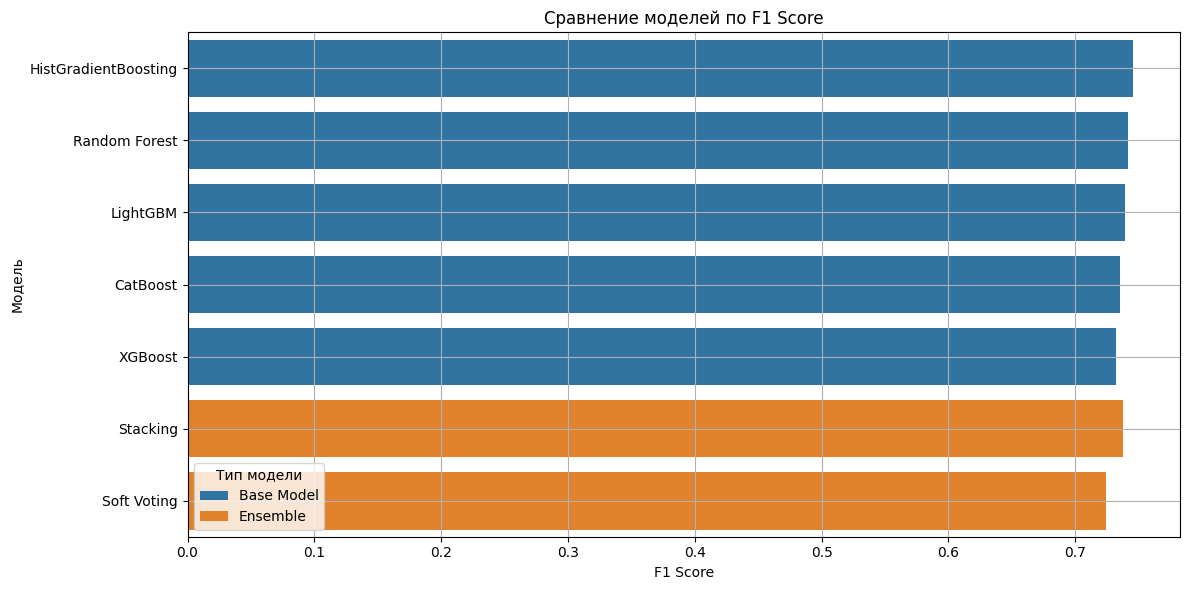

In [ ]:
# --- Сравнение F1 Score ---
combined_df = individual_models_df[['F1 Score']].copy()
combined_df['Type'] = 'Base Model'

ensemble_temp = ensemble_models_df[['F1 Score']].copy()
ensemble_temp['Type'] = 'Ensemble'

combined_df = pd.concat([combined_df, ensemble_temp])

plt.figure(figsize=(12, 6))
sns.barplot(data=combined_df.reset_index(), x='F1 Score', y='index', hue='Type')
plt.title('Сравнение моделей по F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Модель')
plt.legend(title='Тип модели', loc='lower left')  # Перемещаем легенду в левый нижний угол
plt.grid(True)
plt.tight_layout()
plt.show()

Хотя HistGradientBoosting показала наивысший F1 Score, её поведение на ROC-кривой выявило провал в центральной области , что может говорить о нестабильности модели при классификации объектов со средней уверенностью. Это особенно критично, если важен баланс между точностью и полнотой.

В свою очередь, стекинг обеспечивает более равномерное качество по всему диапазону вероятностей , а также демонстрирует высокий уровень ROC AUC. Он позволяет:

    Комбинировать силы нескольких моделей,
    Снизить дисперсию предсказаний,
    Получить более обобщаемое и устойчивое решение.
     

**Таким образом, стекинг является предпочтительным вариантом  для дальнейшего использования в задачах прогнозирования токсичности химических соединений**.
